In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Article Reference: https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/


In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [5]:
image_path = "/content/drive/MyDrive/BT5153/Data/Pict"
dir_img_csv = pd.read_csv("/content/drive/MyDrive/BT5153_transformer_test/Data_processed_reduced_v4.csv",encoding= 'unicode_escape')

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 49111


In [6]:
dir_img_csv['filename'] = dir_img_csv['img_id'].apply(lambda x: str(x)+'.jpg')
dir_img_csv = dir_img_csv[['img_id', 'filename','description']]
dir_img_csv.columns = ['index','filename', 'caption']
data = dir_img_csv.copy()

uni_filenames = np.unique(data.filename.values)
data.head()

,index,filename,caption
0,0,0.jpg,a single layer with a natural feel of natural ...
1,1,1.jpg,light and cool shorts are perfect for relaxing...
2,2,2.jpg,updated to have a relaxed silhouette has a mor...
3,3,3.jpg,shorts inspired by military pants trendy loose...
4,5,5.jpg,kando shorts has been renamed to ultra light s...


In [7]:
'''
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']


uni_filenames = np.unique(data.filename.values)
data.head()
'''

'\nfile = open(dir_Flickr_text,\'r\')\ntext = file.read()\nfile.close()\n\ndatatxt = []\nfor line in text.split(\'\n\'):\n    col = line.split(\'\t\')\n    if len(col) == 1:\n        continue\n    w = col[0].split("#")\n    datatxt.append(w + [col[1].lower()])\n\ndata = pd.DataFrame(datatxt,columns=["filename","index","caption"])\ndata = data.reindex(columns =[\'index\',\'filename\',\'caption\'])\ndata = data[data[\'filename\'] != \'2258277193_586949ec62.jpg.1\']\n\n\nuni_filenames = np.unique(data.filename.values)\ndata.head()\n'

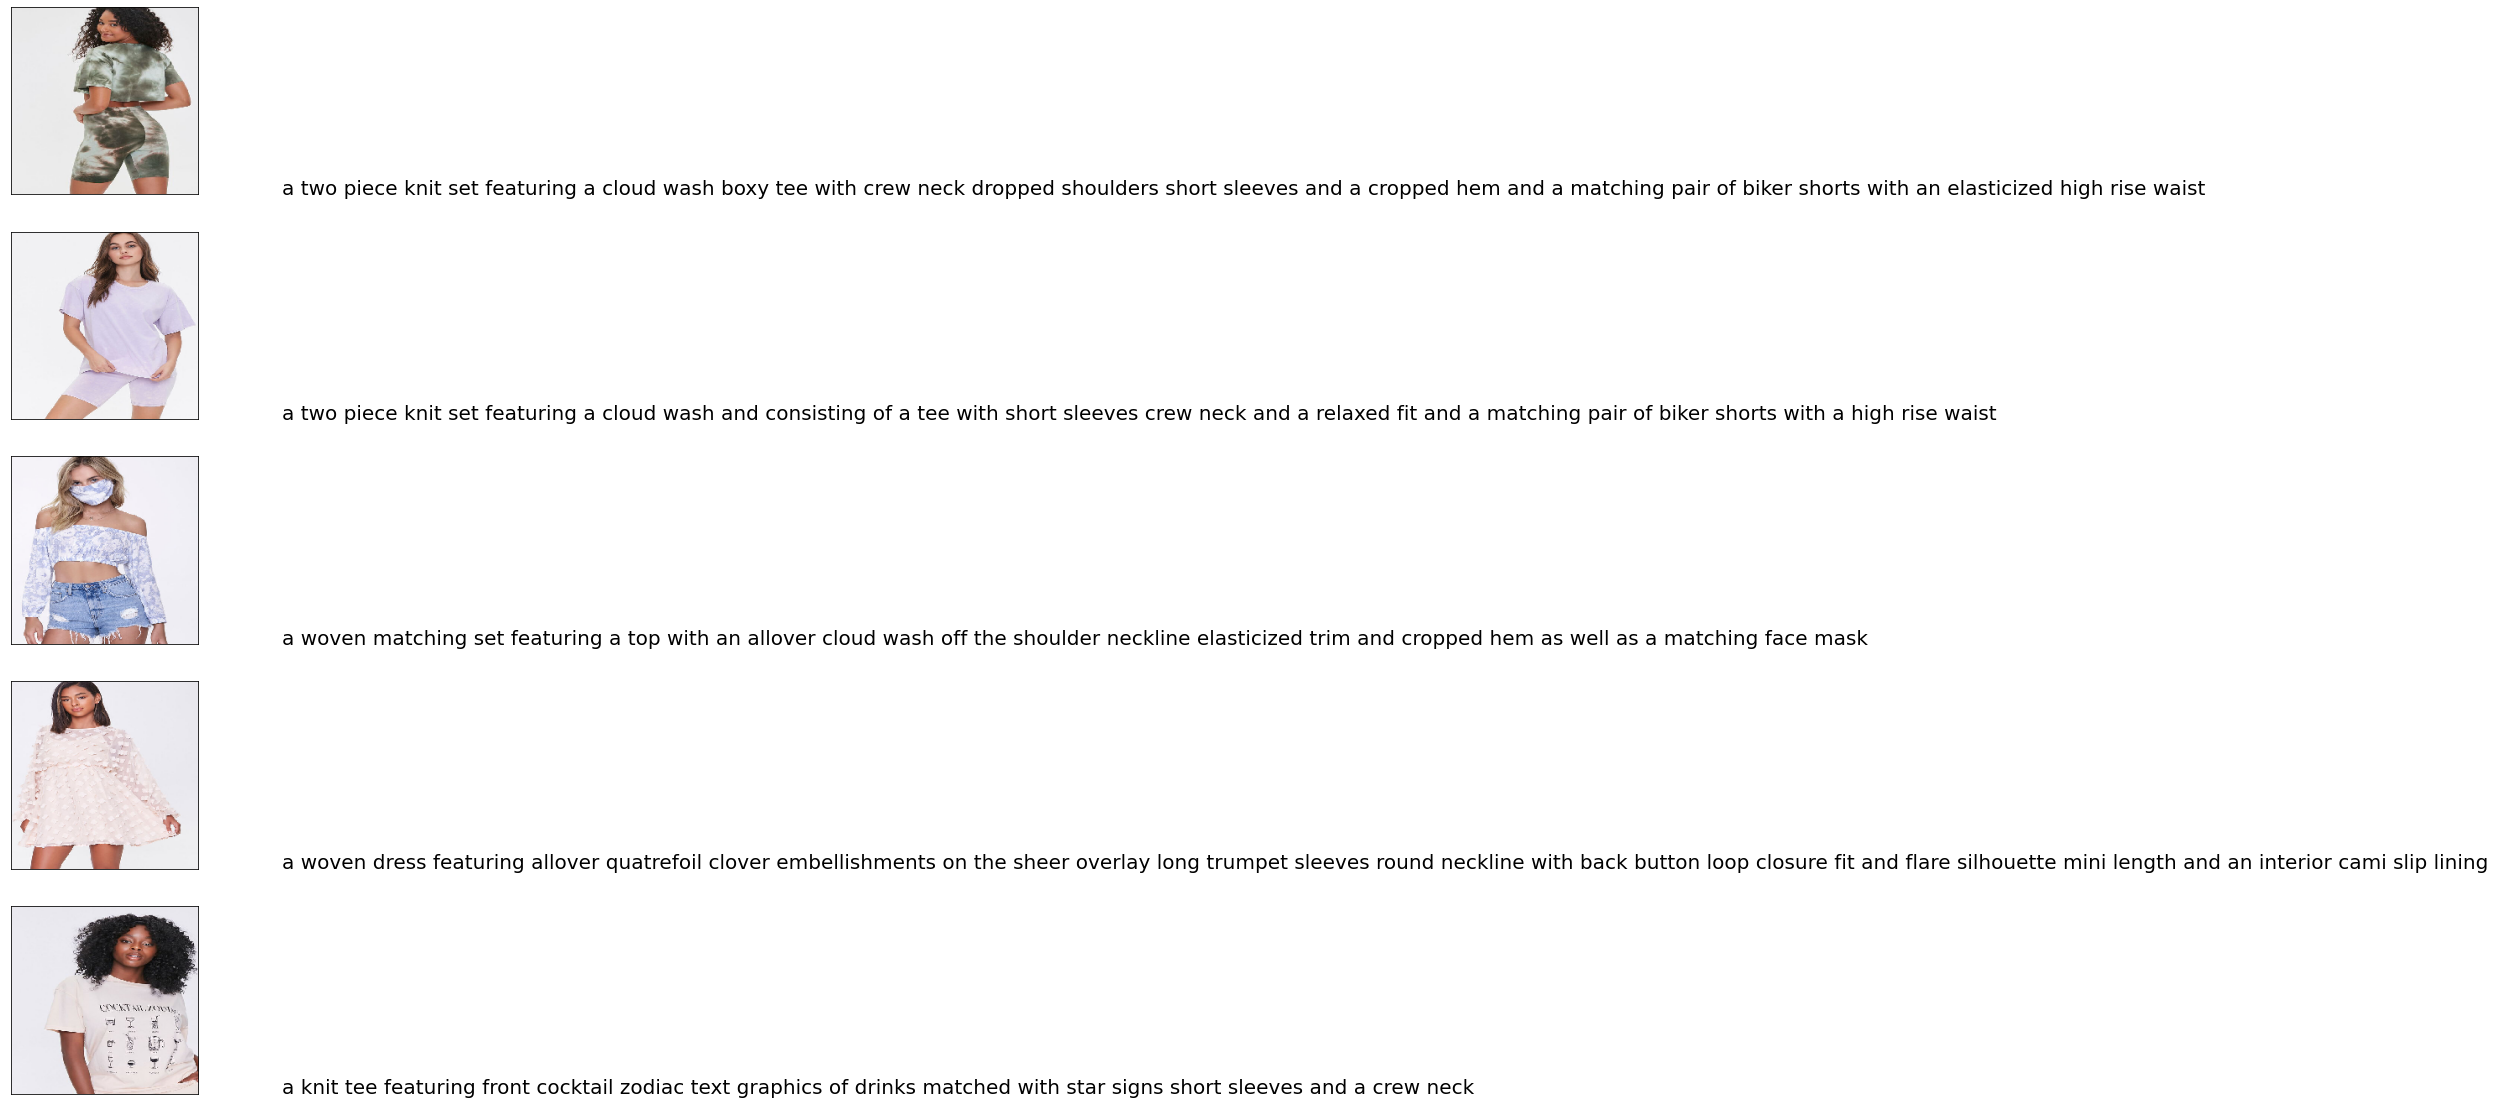

In [8]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [9]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8920


In [10]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [11]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 18680
len(caption) : 18680


In [12]:
'''
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
  '''

'\n# To remove punctuations\ndef remove_punctuation(text_original):\n    text_no_punctuation = text_original.translate(string.punctuation)\n    return(text_no_punctuation)\n\n# To remove single characters\ndef remove_single_character(text):\n    text_len_more_than1 = ""\n    for word in text.split():\n        if len(word) > 1:\n            text_len_more_than1 += " " + word\n    return(text_len_more_than1)\n\n# To remove numeric values\ndef remove_numeric(text):\n    text_no_numeric = ""\n    for word in text.split():\n        isalpha = word.isalpha()\n        if isalpha:\n            text_no_numeric += " " + word\n    return(text_no_numeric)\n  '

In [13]:
'''
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption
'''

'\ndef text_clean(text_original):\n    text = remove_punctuation(text_original)\n    text = remove_single_character(text)\n    text = remove_numeric(text)\n    return(text)\n    \nfor i, caption in enumerate(data.caption.values):\n    newcaption = text_clean(caption)\n    data["caption"].iloc[i] = newcaption\n'

In [14]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8920


In [15]:
PATH = "/content/drive/MyDrive/BT5153/Data/Pict/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start> a single layer with a natural feel of natural material simple and easy to coordinate a natural linen cotton blend fabric for breathability and softness relaxed regular fit that goes great with the the natural feeling of linen material there is a drawstring around the waist for easy adjustment features a streamlined knee length <end>',
 '<start> light and cool shorts are perfect for relaxing convenient pockets for carrying small items pockets have a new shape waist spindle is now on the inside tonal color leaf print <end>',
 '<start> updated to have a relaxed silhouette has a more casual feeling while still being trendy made with cotton twill that is dense and soft to the touch the updates for this season include a slightly more relaxed silhouette that is perfect for pairing with oversized or fitted tops updated to have more casual stitch work <end>',
 '<start> shorts inspired by military pants trendy loose fitting cut the brand u collection is the realization of a dedicated a

In [16]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/0.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/1.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/3.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/5.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/7.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/8.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/10.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/11.jpg']

In [17]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 18680
len(all_captions) : 18680


In [18]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [19]:
train_captions,img_name_vector = data_limiter(30000, all_captions,all_img_name_vector)

In [20]:
img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/4773.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/1541.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/3909.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/20656.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6678.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6072.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6506.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/10365.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/5274.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2442.jpg']

In [21]:
train_captions[:10]

['<start> the smooth fabric with added stretch for comfort makes this denim skirt with a casual button placket and whiskering a versatile spring piece <end>',
 '<start> track pants are a tried and true favorite no matter the season so why not mix it up with some color these slim fitting brand pants play up the contrast between positives and negatives split trefoils circle the knees and keep things in balance this product is made with primegreen a series of high performance recycled materials <end>',
 '<start> crafted from woven fabric with added stretch and wool these business trousers combine comfort with style <end>',
 '<start> calf length dress in woven fabric with plumeti v neck narrow adjustable shoulder straps and smocking at the back concealed zip in one side a seam at the waist and a pleated skirt lined <end>',
 '<start> the wow factor for formal events this blouse beams at full strength <end>',
 '<start> these stretch jeans by clockhouse go wonderfully well with cropped tops t

In [22]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 18680
len(all_captions) : 18680


In [23]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [24]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 1s 0us/step


In [25]:
'''
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
'''

'\n# Get unique images\nencode_train = sorted(set(img_name_vector))\n\n# Feel free to change batch_size according to your system configuration\nimage_dataset = tf.data.Dataset.from_tensor_slices(encode_train)\nimage_dataset = image_dataset.map(\n  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)\n\nfor img, path in tqdm(image_dataset):\n  batch_features = image_features_extract_model(img)\n  batch_features = tf.reshape(batch_features,\n                              (batch_features.shape[0], -1, batch_features.shape[3]))\n\n  for bf, p in zip(batch_features, path):\n    path_of_feature = p.numpy().decode("utf-8")\n    np.save(path_of_feature, bf.numpy())\n'

In [26]:
top_k = 8922

In [27]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [28]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [29]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=62,padding='post')
cap_vector.shape

(18680, 62)

In [30]:
img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/4773.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/1541.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/3909.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/20656.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6678.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6072.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6506.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/10365.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/5274.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2442.jpg']

In [31]:
### load pre-prepared train and test set for consistency
predefined_train = pd.read_csv('/content/drive/MyDrive/BT5153_transformer_test/df_train_v4.csv')
predefined_val = pd.read_csv('/content/drive/MyDrive/BT5153_transformer_test/df_validation_v4.csv')

In [32]:
predefined_train_ids = predefined_train['img_id']
predefined_val_ids = predefined_val['img_id']

In [33]:
img_name_train_trial = []
img_name_val_trial = []
cap_train_trial = []
cap_val_trial = []

for i in range(len(img_name_vector)):
  temp_img = img_name_vector[i]
  temp_img_ids = int(temp_img.split('/')[-1][:-4])
  if temp_img_ids in predefined_train_ids.values:
    img_name_train_trial.append(temp_img)
    cap_train_trial.append(cap_vector[i])
  elif temp_img_ids in predefined_val_ids.values:
    img_name_val_trial.append(temp_img)
    cap_val_trial.append(cap_vector[i])
  else:
    continue



In [34]:
cap_val = np.array(cap_val_trial)
cap_train = np.array(cap_train_trial)
img_name_train = img_name_train_trial
img_name_val = img_name_val_trial
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(14944, 14944, 3736, 3736)

In [35]:
'''
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=123)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
'''

'\nimg_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,\n                                                                    cap_vector,\n                                                                    test_size=0.2,\n                                                                    random_state=123)\nlen(img_name_train), len(cap_train), len(img_name_val), len(cap_val)\n'

In [36]:
cap_train.shape

(14944, 62)

In [37]:
img_name_train_new = [] 
for i in img_name_train:
  temp_split = i.split("/")
  temp_file = temp_split[-1][:-4]
  temp_new_path = "/".join(temp_split[:-2]+['Pict_features_transformer', temp_file])
  img_name_train_new.append(temp_new_path)

img_name_train = img_name_train_new

In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [39]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [41]:
num_layer = 6 # original = 4
d_model = 50 # original = 96
dff = 2048
num_heads = 5 # original = 8
row_size = 8 # original = 8  
col_size = 8 # original = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [44]:
for epoch in range(10):  
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.4238 Accuracy 0.0000
Epoch 1 Batch 50 Loss 9.3917 Accuracy 0.0013
Epoch 1 Batch 100 Loss 9.3344 Accuracy 0.0131
Epoch 1 Batch 150 Loss 9.2483 Accuracy 0.0176
Epoch 1 Batch 200 Loss 9.1274 Accuracy 0.0208
Epoch 1 Loss 9.0308 Accuracy 0.0220
Time taken for 1 epoch: 5629.844773769379 secs

Epoch 2 Batch 0 Loss 8.2935 Accuracy 0.0325
Epoch 2 Batch 50 Loss 8.0528 Accuracy 0.0314
Epoch 2 Batch 100 Loss 7.8095 Accuracy 0.0334
Epoch 2 Batch 150 Loss 7.5666 Accuracy 0.0350
Epoch 2 Batch 200 Loss 7.3382 Accuracy 0.0366
Epoch 2 Loss 7.2042 Accuracy 0.0376
Time taken for 1 epoch: 809.9802401065826 secs

Epoch 3 Batch 0 Loss 6.2719 Accuracy 0.0540
Epoch 3 Batch 50 Loss 6.1842 Accuracy 0.0516
Epoch 3 Batch 100 Loss 6.1018 Accuracy 0.0529
Epoch 3 Batch 150 Loss 6.0343 Accuracy 0.0546
Epoch 3 Batch 200 Loss 5.9419 Accuracy 0.0583
Epoch 3 Loss 5.8816 Accuracy 0.0613
Time taken for 1 epoch: 823.8564927577972 secs

Epoch 4 Batch 0 Loss 5.1947 Accuracy 0.0927
Epoch 4 Batch 50 Loss 5

In [45]:
transformer.save_weights('/content/drive/MyDrive/BT5153_transformer_test/Model_weights/5153_transformer_v4.h5')

In [46]:
def evaluate_beam(image, beam_index):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens

  log_prob = 0.0
  candidates = [[output, log_prob]]

  while len(tf.reshape(candidates[-1][0], -1)) < 32:
    temp = []
    for candidate in candidates:
      output = candidate[0]
      dec_mask = create_masks_decoder(output)

      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      # select top probabilities according to beam_index
      word_preds = np.argsort(predictions).reshape(-1)[-beam_index:]

      for w in word_preds:
        next_cap, prob = candidate[0][:], candidate[1]
        next_cap = tf.concat([next_cap, tf.expand_dims([w],0)], axis=-1)
        prob += np.log(tf.squeeze(predictions[:, :, w], axis=-1)[0])
        temp.append([next_cap, prob])
      
    candidates = temp
    # sort according to probabilities (higher log prob, better)
    candidates = sorted(candidates, reverse=False, key=lambda l:l[1])
    # get top candidates
    candidates = candidates[-beam_index:]

  # select best candidate
  best_candidate = tf.reshape(candidates[-1][0], -1)
  intermediate_caption = [tokenizer.index_word[int(i)] for i in best_candidate]

  final_caption = []

  for i in intermediate_caption:
    if i != '<end>':
      final_caption.append(i)
    else:
      break

  final_caption = ' '.join(final_caption[1:])
  return final_caption

BLEU-1 score: 10.6931392899502
BLEU-2 score: 12.961422209442407
BLEU-3 score: 14.28909194582599
BLEU-4 score: 11.655240364649593
Real Caption: can be paired with trainers courts or boots this basic stretch pencil skirts is the perfect foundation for a wide variety of styles
Predicted Caption: this flowy blouse with a fine lace trim and a fine lace trim
Predicted Beam Caption: this long sleeve top by clockhouse is a casual piece for the office looks


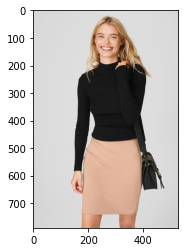

In [47]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(32):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)
caption_beam = evaluate_beam(image, 2)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0), smoothing_function = SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0), smoothing_function = SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0), smoothing_function = SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function = SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
print ('Predicted Beam Caption:', caption_beam)
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [48]:
df_val_results = pd.DataFrame(columns=['img_path','real_caption','predicted_caption','bleu_1', 'bleu_2', 'bleu_3', 'bleu_4'])

In [49]:
range(len(img_name_val))

range(0, 3736)

In [51]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
for rid in range(3601, len(img_name_val)): #range(len(img_name_val)):

  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
        caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption
  score_1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0), smoothing_function = SmoothingFunction().method4)
  score_2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0), smoothing_function = SmoothingFunction().method4)
  score_3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0), smoothing_function = SmoothingFunction().method4)
  score_4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function = SmoothingFunction().method4)

  temp_val_df = pd.DataFrame({
      'img_path':[image],
      'real_caption':[real_caption],
      'predicted_caption':[' '.join(caption)],
      'bleu_1':[score_1], 
      'bleu_2':[score_2], 
      'bleu_3':[score_3], 
      'bleu_4':[score_4]
  })

  df_val_results = pd.concat([df_val_results, temp_val_df], axis=0)
  if rid % 200 == 0:
    df_val_results.to_csv('/content/drive/MyDrive/BT5153_transformer_test/Val_resutls/transformer_v4_BLEU_rest.csv', index=False)


In [52]:
df_val_results['img_id'] = df_val_results['img_path'].apply(lambda x: x.split('/')[-1][:-4])

In [53]:
df_val_results.head()

,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4,img_id
0,/content/drive/MyDrive/BT5153/Data/Pict/16507.jpg,a ribbed sweater knit polo shirt featuring a b...,a ribbed knit top featuring a v neckline and l...,0.256385,0.143732,0.142313,0.112718,16507
0,/content/drive/MyDrive/BT5153/Data/Pict/30845.jpg,knitted cardigan regular fit soft and stretchy...,a ribbed knit top featuring a round neckline l...,0.020512,0.020174,0.020389,0.016290,30845
0,/content/drive/MyDrive/BT5153/Data/Pict/6530.jpg,thanks to the stretch fabric these jeans fit p...,these slim fit jeans are a casual look with a ...,0.235294,0.291726,0.320821,0.262447,6530
0,/content/drive/MyDrive/BT5153/Data/Pict/6113.jpg,a stylish all rounder padded bra with detachab...,the floral lace trim and a semi sheer cups giv...,0.200000,0.265076,0.300960,0.247782,6113
0,/content/drive/MyDrive/BT5153/Data/Pict/4780.jpg,can be worn solo or layered as a vest clockhou...,this long sleeve top with a fine lace trim and...,0.166287,0.086539,0.119252,0.102851,4780


In [54]:
df_val_results.to_csv('/content/drive/MyDrive/BT5153_transformer_test/Val_resutls/transformer_v4_BLEU_all_rest.csv', index=False)

In [ ]:
df_val_results_beam = pd.DataFrame(columns=['img_path','real_caption','predicted_caption','bleu_1', 'bleu_2', 'bleu_3', 'bleu_4'])

for rid in range(len(img_name_val)):
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in real_caption:
    if i=="<unk>":
      real_caption.remove(i)

  caption_beam = evaluate_beam(image, 2)
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption_beam.split()
  score_1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0), smoothing_function = SmoothingFunction().method4)
  score_2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0), smoothing_function = SmoothingFunction().method4)
  score_3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0), smoothing_function = SmoothingFunction().method4)
  score_4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function = SmoothingFunction().method4)

  temp_val_df = pd.DataFrame({
      'img_path':[image],
      'real_caption':[real_caption],
      'predicted_caption':[caption_beam],
      'bleu_1':[score_1], 
      'bleu_2':[score_2], 
      'bleu_3':[score_3], 
      'bleu_4':[score_4]
  })
  df_val_results_beam = pd.concat([df_val_results_beam, temp_val_df], axis=0)
  if rid % 200 == 0:
    df_val_results_beam.to_csv('/content/drive/MyDrive/BT5153_transformer_test/Val_resutls/transformer_v4_BLEU_Beam.csv', index=False)

In [ ]:
df_val_results_beam['img_id'] = df_val_results_beam['img_path'].apply(lambda x: x.split('/')[-1][:-4])

In [ ]:
df_val_results_beam.head()

In [ ]:
df_val_results_beam.to_csv('/content/drive/MyDrive/BT5153_transformer_test/Val_resutls/transformer_v4_BLEU_Beam_all.csv', index=False)